## Introduction

The examples used in this competition are fairly popular, but some of the code used for data wrangling has been taken from this article (thanks Tomonori Masui!). You should check out the article to see how a few other models perform on these datasets.

The first example is a fairly well known time-series: the Airline Passenger dataset. This data is widely available and one source is from Kaggle or from the Github. Make sure you have the latest ThymeBoost package which can be installed via pip:

In [ ]:
pip install ThymeBoost --upgrade

### Airline Passenger Dataset

       Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]


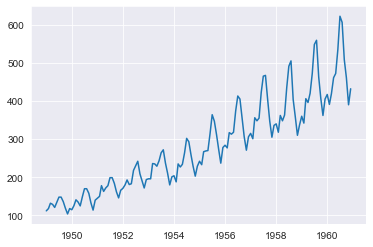

In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from ThymeBoost import ThymeBoost as tb
import seaborn as sns
sns.set_style("darkgrid")
#Airlines Data, if your csv is in a different filepath adjust this
df = pd.read_csv('AirPassengers.csv')
print(df)
df.index = pd.to_datetime(df['Month'])
y = df['#Passengers']
plt.plot(y)
plt.show()

This time series is quite interesting! A clear trend along with multiplicative seasonality. Definitely a good benchmark for any forecasting methodology.

In order to judge the forecasting methods, we will split the data into a standard train/test split where the last 30% of the data is held out. The outcome of the testing procedure can change depending on this split. In an attempt to remain unbiased, the train/test splits from the aforementioned article will be used.

Any tuning or model selection will be done on the training set while the test set will be used to judge the methods. The goal (at least for me) is to see if ThymeBoost can be competitive against other vetted methods. If you were to implement a forecasting model in production, then you may want to use a more robust method to judge models such as time-series cross validation

In [21]:
test_len = int(len(y) * 0.3)
al_train, al_test = y.iloc[:-test_len], y.iloc[-test_len:]

##### First, let’s try out an Auto-Arima implementation: Pmdarima.(http://alkaline-ml.com/pmdarima/)

In [22]:
import pmdarima as pm
# Fit a simple auto_arima model
arima = pm.auto_arima(al_train,
                      seasonal=True,
                      m=12,
                      trace=True,
                      error_action='warn',
                      n_fits=50)
pmd_predictions = arima.predict(n_periods=len(al_test))
arima_mae = np.mean(np.abs(al_test - pmd_predictions))
arima_rmse = (np.mean((al_test - pmd_predictions)**2))**.5
arima_mape = np.sum(np.abs(pmd_predictions - al_test)) / (np.sum((np.abs(al_test))))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=766.298, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=765.723, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=764.756, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=765.328, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=764.138, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=764.944, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=766.619, Time=0.15 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=765.206, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=762.550, Time=0.08 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=765.329, Time=0.14 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=765.510, Time=0.16 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=767.126, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=764.631, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=766.465, Time=0.06 sec
 ARIMA(1,1,2)(0,1,0)[12]         

##### Next, we will give Prophet a shot.

In [23]:
from fbprophet import Prophet
prophet_train_df = al_train.reset_index()
prophet_train_df.columns = ['ds', 'y']
prophet = Prophet(seasonality_mode='multiplicative')
prophet.fit(prophet_train_df)
future_df = prophet.make_future_dataframe(periods=len(al_test), freq='M')
prophet_forecast = prophet.predict(future_df)
prophet_predictions = prophet_forecast['yhat'].iloc[-len(al_test):]
prophet_mae = np.mean(np.abs(al_test - prophet_predictions.values))
prophet_rmse = (np.mean((al_test - prophet_predictions.values)**2))**.5
prophet_mape = np.sum(np.abs(prophet_predictions.values - al_test)) / (np.sum((np.abs(al_test))))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Finally, implementing **ThymeBoost**. Here we are using a new method: ‘autofit’ from the latest version of the package. This method will try several simple implementations given a possible seasonality. It is an experimental feature and only works for traditional time-series. A current issue is that it tries several redundant parameter settings, this will be fixed in a future release, speeding up the process! Additionally, if you intend to pass exogenous factors we recommend using the optimize method found in the README instead.

In [24]:
boosted_model = tb.ThymeBoost(verbose=0)
output = boosted_model.autofit(al_train,
                               seasonal_period=12)
predicted_output = boosted_model.predict(output, len(al_test))
tb_mae = np.mean(np.abs(al_test - predicted_output['predictions']))
tb_rmse = (np.mean((al_test - predicted_output['predictions'])**2))**.5
tb_mape = np.sum(np.abs(predicted_output['predictions'] - al_test)) / (np.sum((np.abs(al_test))))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.69it/s]


Optimal model configuration: {'trend_estimator': 'arima', 'fit_type': 'global', 'seasonal_period': [12], 'arima_order': 'auto', 'seasonal_estimator': 'fourier', 'global_cost': 'mse', 'additive': False, 'seasonality_weights': None, 'exogenous': None}
Params ensembled: False


By setting verbose=0 when building the class it silences the logging of each individual model. Instead, a progress bar will be displayed to denote progress through the different parameter settings as well as the ‘optimal’ settings found. By default, ThymeBoost’s autofit method will do 3 rounds of fitting and forecasting. This process rolls through the last 6 values of the training set to choose the ‘best’ settings. For this data, the optimal settings found were:

In [25]:
Optimal model configuration: {'trend_estimator': 'linear', 'fit_type': 'local', 'seasonal_period': [12, 0], 'seasonal_estimator': 'fourier', 'connectivity_constraint': True, 'global_cost': 'maicc', 'additive': False, 
                              'seasonality_weights': array([1, 1, 1, 1, 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]), 'exogenous': None}
Params ensembled: False

SyntaxError: invalid syntax (Temp/ipykernel_21304/2602741996.py, line 1)

# Some important things to note:

1. ‘additive’ is set to false, meaning that the entire process is ‘multiplicative’ i.e. the log is taken of the input series. Normal ‘multiplicative’ seasonality is not yet implemented.

2. There is an array of ‘seasonality_weights’ where the last 2 ‘seasonal_periods’ are set to 5, meaning those periods impact the seasonality component 5 times more than the other periods.

3. ‘seasonal_period’ is [12, 0] so it cycles back and forth between measuring seasonality and not measuring it.This is interesting behavior but it essentially adds some regularization to the seasonality component.

Speaking of components, let’s take a look:

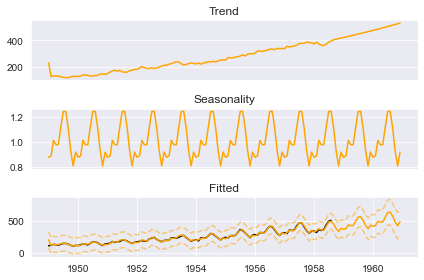

In [26]:
boosted_model.plot_components(output, predicted_output)

All in all, ThymeBoost decided to take the log of the input series, fit a linear changepoint model, and add a ‘changepoint’ to the seasonality component.

Were these correct decisions? Let’s take a look at the error metrics:

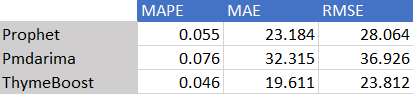

These error metrics speak for themselves, ThymeBoost outperformed the other methods across the board. But what do the forecasts actually look like?

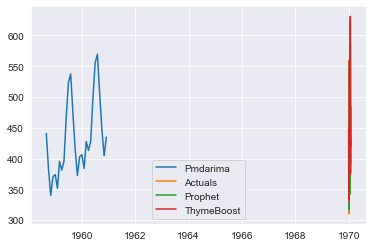

In [27]:
plt.plot(pmd_predictions, label='Pmdarima')
plt.plot(al_test.values, label='Actuals')
plt.plot(prophet_predictions.values, label='Prophet')
plt.plot(predicted_output['predictions'].values, label='ThymeBoost')
plt.legend()
plt.show()

### Conclusion

The goal of this article was to see if ThymeBoost can compete against other popular methods, it clearly can in these instances. But don’t be fooled into thinking ThymeBoost is a panacea (although I wish it was!). There are many times where it is outperformed, however, one major benefit is that any method which outperforms ThymeBoost could potentially be added into the framework. Once a method is added, it gains access to some interesting features via the boosting process.